#Klasifikasi Penyakit Diabetes Melitus

##Import Library dan Dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import os

In [ ]:
!wget -O "diabetes_melitus.csv" "https://raw.githubusercontent.com/NabillahAzzam/LVQ_Diabetes/main/diabetes.csv"

--2023-11-24 01:20:04--  https://raw.githubusercontent.com/NabillahAzzam/LVQ_Diabetes/main/diabetes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23106 (23K) [text/plain]
Saving to: ‘diabetes_melitus.csv’

diabetes_melitus.cs 100%[===================>]  22.56K  --.-KB/s    in 0.002s  

2023-11-24 01:20:05 (14.4 MB/s) - ‘diabetes_melitus.csv’ saved [23106/23106]



In [ ]:
data = pd.read_csv("diabetes_melitus.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
data.shape

(768, 9)

##Data Preprocessing


In [ ]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [ ]:
data.duplicated().sum()

0

In [ ]:
selected_features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']
selected_features

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction']

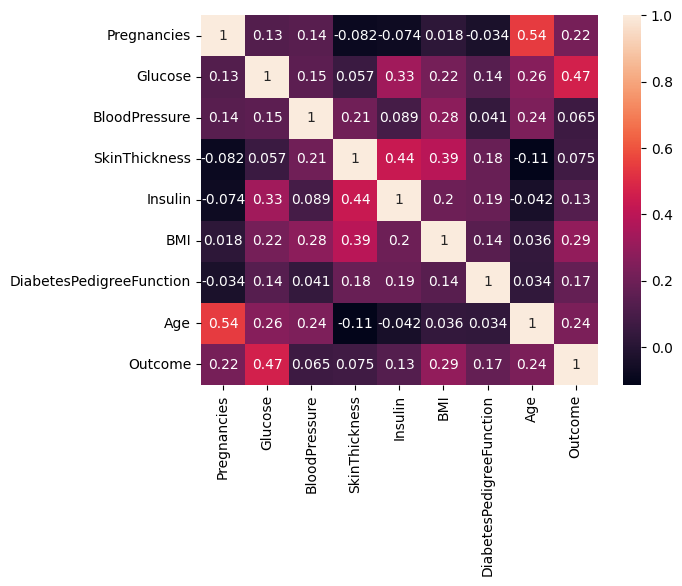

In [ ]:
# Korelasi antar fitur
sns.heatmap(data.corr(),annot = True)
plt.show()

##Pemodelan Training Dataset

In [ ]:
X = data[selected_features] # Independent Values
y = data['Outcome'] # Targeted Values Selection

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Penskalaan Min-Max
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Membuat model LVQ
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

n_input_neurons  = X_train.shape[1]
n_output_neurons = len(np.unique(y_train))

print('Input Neurons:', n_input_neurons)
print('Output Neurons:', n_output_neurons)

Input Neurons: 7
Output Neurons: 2


In [ ]:
class LVQ(object):

    def __init__(self, sizeInput, sizeOutput, max_epoch, learning_rate, learning_function):

        self.sizeInput = sizeInput
        self.sizeOutput = sizeOutput
        self.max_epoch = max_epoch
        self.alpha = learning_rate
        self.learning_function = learning_function
        self.weight = np.zeros((sizeOutput, sizeInput))

    def getWeight(self):
        return self.weight

    def train(self, train_data, train_target):
        weight_label, label_index = np.unique(train_target, return_index=True)

        self.weight = train_data[label_index].astype(np.float)

        train_data = np.delete(train_data, label_index, axis=0)
        train_target = np.delete(train_target, label_index, axis=0)

        epoch = 0
        iteration = 0

        while epoch <= self.max_epoch:
            epoch += 1
            for data, target in zip(train_data, train_target):
                iteration += 1
                distance = np.sqrt(np.sum((data - self.weight) ** 2, axis=1))
                idx_min = np.argmin(distance)

                if target == weight_label[idx_min]:
                    self.weight[idx_min] += self.alpha * (data - self.weight[idx_min])
                else:
                    self.weight[idx_min] -= self.alpha * (data - self.weight[idx_min])

            self.alpha = self.alpha - (self.learning_function * self.alpha)

        weight_class = (self.weight, weight_label)
        return weight_class

    def test(self, test_data, weight_class):
        weight, label = weight_class
        output = []
        for data in test_data:
            distance = np.sqrt(np.sum((data - self.weight) ** 2, axis=1))
            idx_min = np.argmin(distance)
            output.append(label[idx_min])

        return output

In [ ]:
# Inisialisasi objek LVQ
lvq = LVQ(sizeInput=n_input_neurons, sizeOutput=n_output_neurons, max_epoch=100, learning_rate=0.01, learning_function=0.2)

# Pelatihan LVQ menggunakan data pelatihan
weights_and_labels = lvq.train(X_train, y_train)
trained_weights = lvq.getWeight()

print('Trained Weights:', trained_weights)
print('Size of Weights:', trained_weights.shape)

<ipython-input-10-aefbcfc5c4f4>:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.weight = train_data[label_index].astype(np.float)


Trained Weights: [[0.15433953 0.49839305 0.55448129 0.19484221 0.07296059 0.42849321
  0.15216073]
 [0.35823128 0.81351219 0.59443994 0.2626272  0.15773865 0.5758836
  0.28671494]]
Size of Weights: (2, 7)


##Testing dataset

In [ ]:
# Pengujian LVQ menggunakan data pengujian
y_pred = lvq.test(X_test, weights_and_labels)
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy:', accuracy)

Accuracy: 0.7619047619047619


In [ ]:
# Menghitung matriks kebingungan
conf_matrix = confusion_matrix(y_pred, y_test)

print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[127  32]
 [ 23  49]]


In [ ]:
# Mencetak laporan klasifikasi
class_report = classification_report(y_pred, y_test)

print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.80      0.82       159
           1       0.60      0.68      0.64        72

    accuracy                           0.76       231
   macro avg       0.73      0.74      0.73       231
weighted avg       0.77      0.76      0.77       231



## Visualisasi Data

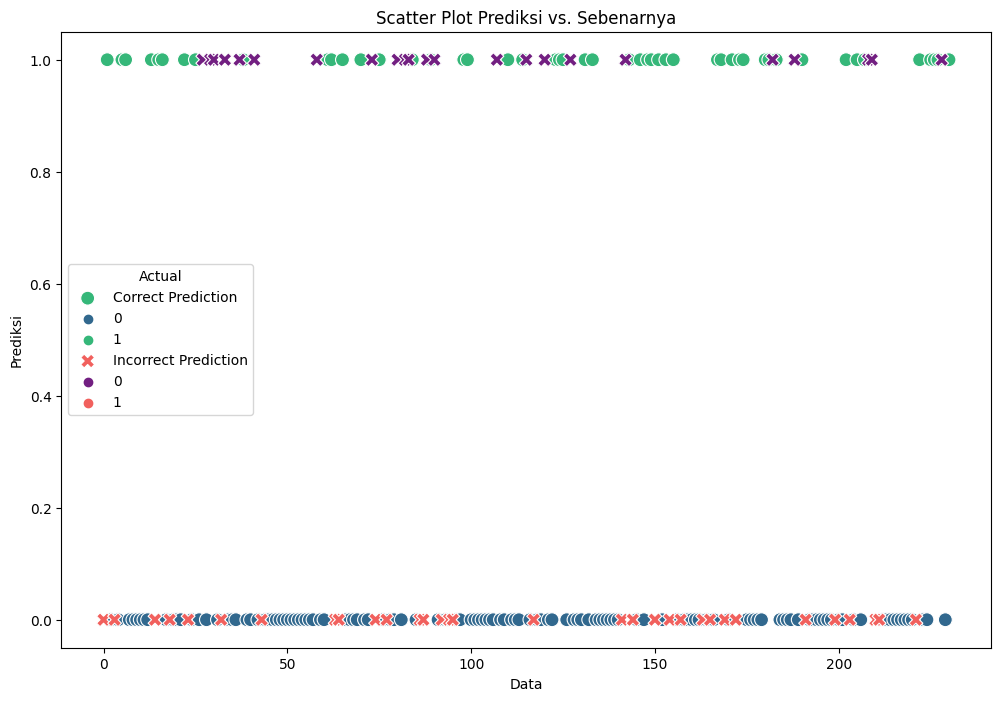

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Membuat DataFrame untuk plotting
df_plot = pd.DataFrame({'Data': range(len(y_test)), 'Actual': y_test, 'Predicted': y_pred})

# Membuat scatter plot
plt.figure(figsize=(12, 8))

# Menampilkan prediksi yang benar
sns.scatterplot(x='Data', y='Predicted', data=df_plot[df_plot['Actual'] == df_plot['Predicted']],
                hue='Actual', palette='viridis', s=100, label='Correct Prediction')

# Menampilkan prediksi yang salah
sns.scatterplot(x='Data', y='Predicted', data=df_plot[df_plot['Actual'] != df_plot['Predicted']],
                hue='Actual', palette='magma', marker='X', s=100, label='Incorrect Prediction')

plt.title('Scatter Plot Prediksi vs. Sebenarnya')
plt.xlabel('Data')
plt.ylabel('Prediksi')
plt.legend(title='Actual', loc='center left')
plt.show()